In [1]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers import Activation, RepeatVector
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, History


In [2]:
def get_notes():

    notes = []
    for file in glob.glob("lofi_songs/*.mid"):
        try:
            midi = converter.parse(file)
        except:
            print('no time signature for '+ file)
            continue
        print(file)
        notes_to_parse = None
        s2 = instrument.partitionByInstrument(midi)
        notes_to_parse = s2.parts[0].recurse()
        for e in notes_to_parse:
            if isinstance(e, note.Note):
                notes.append(str(e.pitch))
            elif isinstance(e, chord.Chord):
                notes.append('.'.join(str(n) for n in e.normalOrder))
    
    return notes

In [3]:
def prepare_sequences(notes, n_notes):

    sequence_length = 50
    pitchnames = sorted(set(item for item in notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []
    
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    normalized_input = normalized_input / float(n_notes)
    network_output = np_utils.to_categorical(network_output)

    return (network_input, normalized_input, network_output)

In [7]:
def create_network(normalized_input, n_notes):
    
    model = Sequential()
    model.add(CuDNNLSTM(512,input_shape=(normalized_input.shape[1], normalized_input.shape[2]),return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(CuDNNLSTM(512, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(CuDNNLSTM(512)))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_notes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    return model

In [8]:
notes = get_notes()
n_notes = len(set(notes))

network_input, normalized_input,network_output = prepare_sequences(notes, n_notes)

model = create_network(normalized_input, n_notes)
history = History()
    
n_epochs = 50
model.summary()
model.fit(normalized_input, network_output, callbacks=[history], epochs=n_epochs, batch_size=64)
model.save('Models/LSTMmodel3_New.h5')



lofi_songs\1.mid
lofi_songs\10.mid
lofi_songs\11.mid
lofi_songs\12.mid
lofi_songs\13.mid
lofi_songs\14.mid
lofi_songs\15.mid
lofi_songs\16.mid
lofi_songs\17.mid
lofi_songs\18.mid
lofi_songs\19.mid
lofi_songs\2.mid
lofi_songs\20.mid
lofi_songs\3.mid
lofi_songs\4.mid
lofi_songs\5.mid
lofi_songs\6.mid
lofi_songs\7.mid
lofi_songs\8.mid
lofi_songs\9.mid
lofi_songs\Cymatics - Eternity MIDI 1 - C Maj.mid
lofi_songs\Cymatics - Eternity MIDI 10 - F Min.mid
lofi_songs\Cymatics - Eternity MIDI 11 - A Maj.mid
lofi_songs\Cymatics - Eternity MIDI 12 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 13 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 14 - A Min.mid
lofi_songs\Cymatics - Eternity MIDI 15 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 16 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 17 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 18 - A# Maj.mid
lofi_songs\Cymatics - Eternity MIDI 19 - A# Min.mid
lofi_songs\Cymatics - Eternity MIDI 2 - C# Min.mid
lofi_songs\Cymatics - Eternity MI

NameError: name 'self' is not defined

In [6]:
print(normalized_input.shape[1], normalized_input.shape[2])

50 1


In [11]:
def generate_notes(model, network_input, n_notes,start):

    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []
    
    for note_index in range(200):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_notes)
        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        pattern = np.append(pattern,index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [12]:
def create_midi(prediction_output, filename):

    offset = 0
    output_notes = []


    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

In [26]:
#model = load_model('LSTMmodel3_New.h5')

start = np.random.randint(0, len(network_input)-1)

generated_output = generate_notes(model, network_input, len(set(notes)),start)
create_midi(generated_output, 'outputs/lofi_midi_latest_2')

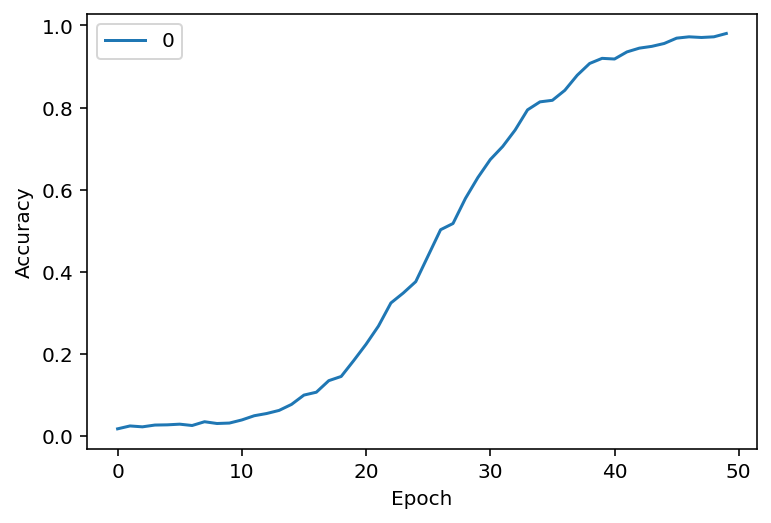

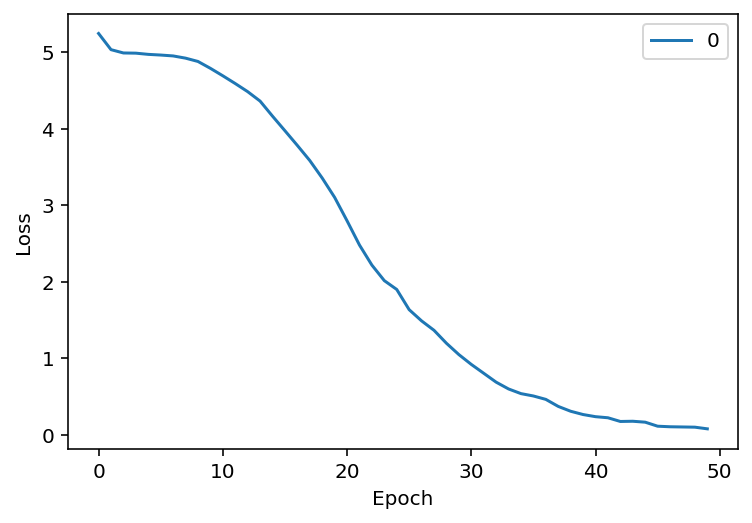

In [14]:
pd.DataFrame(history.history['accuracy']).plot()
plt.savefig('GraphsMetrics/LSTM_per_Epoch_Accuracy.png', transparent=True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

pd.DataFrame(history.history['loss']).plot()
plt.savefig('GraphsMetrics/LSTM_per_Epoch_Loss.png', transparent=True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.close()

In [25]:
print(notes)

['6.9.11.1.2', '6.9.11.2', '11.2.4.7', '1.2.4.6.9', '6.9.11.1.2', '6.9.11.2', '11.2.4.7', '1.2.4.6.9', '6.9.11.1.2', '9.11.0.2.4', 'E4', 'G4', 'E5', '11.2.4.6.7', 'F#4', 'E5', 'B4', 'G5', '9.11.0.2.4', 'E4', 'G4', 'E5', '11.2.4.6.7', 'F#4', 'E5', 'G5', '6.7.11.2', 'B4', 'G4', 'D4', '4.5.9.0', 'D5', 'G5', 'G4', '6.7.11.2', 'B4', 'G4', 'D4', '4.5.9.0', 'D5', 'G5', 'G4', '4.5.9.0', '9.0.2.5', '4.7.11', 'G5', 'C6', 'B4', '10.1.5', 'E-5', '5.8.0', '5.8.0', 'F5', '10.1.5', 'F5', 'B-5', '10.1.5', 'E-5', '5.8.0', '5.8.0', 'F5', '10.1.5', 'F5', 'B-5', '4.7.9.0', '2.5.7.9', '9.11.2.4', '7.9.11.2.4', '4.7.9.11.0', 'E4', 'G4', '0.2.4.7', 'C4', 'A4', '6.9.11.2', '4.5.7.9.0', '9.0.2.5', '11.2.4.7', '4.5.9.0', '4.5.7.9.0', '9.0.2.5', '11.2.4.7', '4.5.9.0', '4.7.11', 'E5', '4.7.9.0', '0.4.7', 'E5', '7.9.2', 'B5', 'A5', 'G5', '4.7.11', 'E5', '4.7.9.0', '0.4.7', 'E5', '7.9.2', 'B5', 'A5', 'G5', '10.1.3.6', '6.10.11.1', '6.10.11.1', '10.11.3.6', 'F#3', '1.5.8', 'G#5', 'B-5', '10.1.3.6', '6.10.11.1', '6.1